In [150]:
# Import from local package
import sys
sys.path.append('../model')
import torch
import numpy as np
from tqdm import tqdm as progress_bar
import numba

# Device configuration
device = torch.device("cpu")

In [2]:
import matplotlib.pyplot as plt

In [8]:
from models import SimpleCNN3Layer as Model
from collectdata import DataCollector

In [9]:
collector = DataCollector(
    "/data/schreihf/PvFinder/Aug_15_140000.npz",
    120_000, 10_000)

Loaded /data/schreihf/PvFinder/Aug_15_140000.npz in 8.927 s
Samples in Training: 120000 Validation: 10000 Test: 10000


In [10]:
validation = collector.get_validation(1)

Constructing dataset on cpu took 0.4116 s


In [11]:
name = '../model/output3/20180815_120000_3layer_30.pyt'
model = Model().to(device)
model.load_state_dict(torch.load(name))
model.eval()

SimpleCNN3Layer(
  (conv1): Conv1d(1, 10, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(10, 5, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(5, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3dropout): Dropout(p=0.35)
  (fc1): Linear(in_features=4000, out_features=4000, bias=True)
)

## Old version

In [13]:
# Check False Positive
def testNet2(model, test_loader):
    FP_list=[]
    N=0
    Times=0
    NO_Batch=0
    FP=0
    
    
    with torch.no_grad():
        for inputs, labels in progress_bar(test_loader):
            NO_Batch = NO_Batch +1
            
            #Forward pass
            outputs = model(inputs)
            
            
            prob=0
            Tprob=0
            j=0

            while j < 3900:
                for i in range (j,j+1):
                    if outputs[0][i].item()> 1e-2 and labels[0][i].item()==0:
                        for jj in range (i,i+10):
                            Tprob+=labels[0][jj].item()
                            prob+=outputs[0][jj].item()
                            if outputs[0][jj]>0.01:
                                Times=Times+1      
                        if Tprob<0.9 and prob>0.2 and Times>=3:
                            FP=FP+1
                            FP_list.append((NO_Batch, j))
                            j+=10
                        else:
                            j+=1
                    else:
                        j+=1
                            
    return FP

In [14]:
FP = testNet2(model, validation)
print(FP)

100%|██████████| 10000/10000 [02:12<00:00, 75.41it/s]

2348


## Modern Version

In [35]:
@numba.jit(numba.int32(numba.float32[:],numba.float32[:]))
def look_for_missing(outputs, labels):
    prob = 0
    Tprob = 0
    j = 0
    FP = 0

    while j < 3900:
        
        for i in range (j, j+1):
            
            # If output value and not label value
            if outputs[i] > 1e-2 and labels[i] == 0:
                
                # Scan the next ten cells
                for jj in range(i, i+10):
                    Tprob += labels[jj]
                    prob += outputs[jj]
                    
                        
                # If label_prob is small and output_prob is large,
                # count a false positive and move on 10 cells
                if Tprob < 0.9 and prob > 0.2:
                    FP += 1
                    j += 10
                else:
                    j += 1
            else:
                j += 1
                
    return FP

In [75]:
# Check False Positive
def testNet3(model, test_loader):
    FP_list=[]
    N=0
    NO_Batch=0
    FP=0
    
    
    with torch.no_grad():
        for inputs, labels in progress_bar(test_loader):
            NO_Batch = NO_Batch +1
            
            #Forward pass
            outputs = model(inputs)
            
            
            value = look_for_missing(outputs[0].numpy(), labels[0].numpy())
            FP += value
                            
    return FP

In [76]:
FP3 = testNet3(model, validation)
print(FP3)

  1%|          | 79/10000 [00:00<00:26, 372.27it/s]

2: 1
4: 2
11: 1
18: 1
20: 1
22: 1
30: 1
35: 1
36: 1
38: 1
47: 1
55: 1
58: 1
62: 2
64: 1
65: 1
71: 1
78: 2
81: 1


86: 1
87: 1
88: 1
99: 1
112: 1
122: 1
134: 1
137: 2
138: 1
147: 2
150: 2
154: 3
156: 1
160: 1
164: 1


  3%|▎         | 314/10000 [00:00<00:18, 517.93it/s]

189: 1
196: 1


100%|██████████| 10000/10000 [00:13<00:00, 737.83it/s]

2348


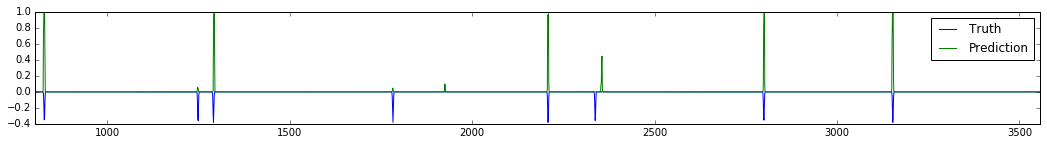

In [95]:
i = 154
Y = validation.dataset.tensors[1][i]
with torch.no_grad():
    out = model(validation.dataset.tensors[0][i][None,:,:])

truth = Y.numpy()
predict = out.numpy().squeeze()

# Find the locations of values so that we can set limits
non_zero, = np.nonzero(np.round(truth + predict, 4))
    
plt.figure(figsize=(18,2))
plt.plot(-truth, label='Truth')
plt.plot(predict, label='Prediction')
plt.xlim(min(non_zero) - 20, max(non_zero) + 400)
plt.legend();

In [128]:
@numba.jit(numba.float32[:](numba.float32[:], numba.float32), nopython=True)
def pv_locations(targets, threshold):
    state = False
    start = 0
    items = np.empty(150, np.float32)
    nitems = 0
    
    for i in range(len(targets)):
        if targets[i] >= threshold and not state:
            state = True
            start = i
        elif targets[i] < threshold and state:
            state = False
            items[nitems] = (i + start) / 2.
            nitems += 1
        # otherwise, keep going
    return items[:nitems]

In [123]:
pv_locations(truth,1e-2)

array([ 828. , 1249. , 1291.5, 1783.5, 2208.5, 2338. , 2800. , 3153.5],
      dtype=float32)

In [129]:
pv_locations(predict, 1e-2)

array([ 827. , 1249. , 1292.5, 1783. , 1925.5, 2208.5, 2355.5, 2800.5,
       3153.5], dtype=float32)

In [125]:
%%timeit
pv_locations(predict, 1e-2)

5.11 µs ± 11.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [127]:
%%timeit
pv_locations(predict, 1e-2)

9.19 ms ± 32.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [138]:
@numba.jit(numba.types.UniTuple(numba.int32,2)(numba.float32[:], numba.float32[:], numba.float32), nopython=True)
def compare(a, b, diff):
    succeed = 0
    fail = 0
    
    # Check for closest value
    for item in a:
        mindiff = np.abs(b-item).min()
        if mindiff > diff:
            fail += 1
        else:
            succeed += 1
    
    return succeed, fail

In [139]:
a = pv_locations(truth, 1e-2)
b = pv_locations(predict, 1e-2)

print(*compare(a, b, 3.))
print(*compare(b, a, 3.))

7 1
7 2


In [145]:
@numba.jit(numba.types.UniTuple(numba.int32,3)(numba.float32[:], numba.float32[:], numba.float32, numba.float32))
def efficency(truth, predict, threshold, difference):
    """
    Compute three value: The number of succeses (S), the number of missed true values (MT), and the number of missed false values (FP).
    
    Accepts:
      * truth: Numpy array of truth values
      * predict: Numpy array of predictions
      * threshold: The threshold for considering an "on" value
      * difference: The maximum difference to count a success, in bin widths (successes and failures are to the nearest half bin, currently)
    
    Returns: S, MT, FP
    
    A future advancement of this algorithm would be to compute the weighted mean, and use that.
    Also, this will currently be triggered by small fluctionations in the input array. It should have a minium total integrated value
    required to "turn it on".
    """
    
    a = pv_locations(truth, threshold)
    b = pv_locations(predict, threshold)

    S, MT = compare(a, b, difference)
    Sp, FP = compare(b, a, difference)
    
    assert S == Sp
    
    return S, MT, FP

In [149]:
%%timeit
efficency(truth, predict, 1e-2, 20.)

11.8 µs ± 38.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
